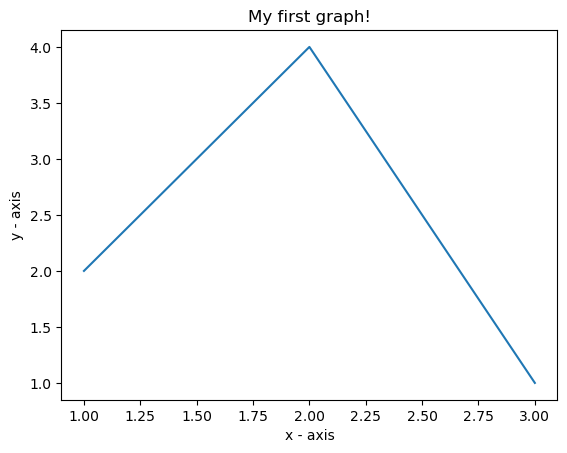

In [0]:
# importing the required module 
import matplotlib.pyplot as plt 
  
# x axis values 
x = [1,2,3] 
# corresponding y axis values 
y = [2,4,1] 
  
# plotting the points  
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
  
# giving a title to my graph 
plt.title('My first graph!') 
  
# function to show the plot 
plt.show() 

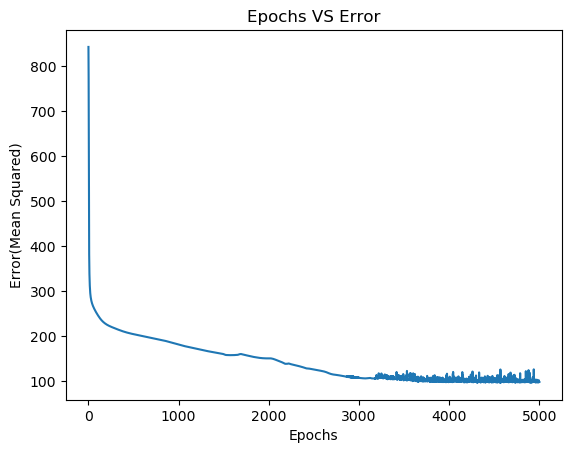

In [0]:
# Backprop on the Seeds Dataset
from random import seed
from random import randrange
from random import random
from random import gauss
from csv import reader
from math import exp
import numpy as np
import matplotlib.pyplot as plt 
from statistics import stdev
# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset
 
# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())
 
# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup
 
# Find the min and max values for each column
def dataset_minmax(dataset):
	minmax = list()
	stats = [[min(column), max(column)] for column in zip(*dataset)]
	return stats
 
# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
	for row in dataset:
		for i in range(len(row)-1):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
 
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split
 

def f_score_metric(actual,predicted):
	true_pos=0
	true_neg=0
	false_pos=0
	false_neg=0
	for i in range(len(actual)):
		if actual[i] == predicted[i] and predicted[i]==1:#true pos
			true_pos += 1
		elif actual[i] == predicted[i] and predicted[i]==0:#true neg
			true_neg += 1
		elif actual[i] ==0 and predicted[i]==1:#false pos
			false_pos+= 1
		else:
			false_neg+=1
	precision =true_pos/(true_pos+false_pos)
	recall = true_pos/(true_pos+false_neg)
	f_score=2*precision*recall/(precision+recall)
	return f_score
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0
 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	accuracies = list()
	f_scores = list()
	errors=list()
	error=None
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		f_score=f_score_metric(actual,predicted)
		accuracies.append(accuracy)
		f_scores.append(f_score)
	
	return accuracies,f_scores
 
# Calculate neuron activation for an input
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation
 
# Transfer neuron activation
def transfer_sigmoid(activation):
    return 1.0 / (1.0 + exp(-activation))#sigmoid
def transfer_relu(activation):
    return max(0,activation)#relu	

# Forward propagate input to a network output
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'],inputs)
			neuron['output'] = transfer_sigmoid(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs
 
# Calculate the derivative of an neuron output
def transfer_derivative_sigmoid(output):
	return output * (1.0 - output)

def transfer_derivative_relu(output):
	if output<=0:
		return 0
	else:
		return 1
 
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(expected[j] - neuron['output'])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative_sigmoid(neuron['output'])
 
# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] += l_rate * neuron['delta']

# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
	errors = list()
	sum_error=None
	for epoch in range(n_epoch):
		sum_error = 0
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			sum_error+= np.linalg.norm(np.array([x1 - x2 for (x1, x2) in zip(outputs, expected)]))
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)
		#print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
		errors.append(sum_error) 
	x = [i for i in range(1,len(errors)+1)] 
	# corresponding y axis values 
	y = errors 

	# plotting the points  
	plt.plot(x, y) 

	# naming the x axis 
	plt.xlabel('Epochs') 
	# naming the y axis 
	plt.ylabel('Error(Mean Squared)') 

	# giving a title to my graph 
	plt.title('Epochs VS Error') 

	# function to show the plot 
	plt.show()

# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer_1 = [{'weights':[gauss(0,1) for i in range(n_inputs + 1)]} for i in range(n_hidden[0])]
	network.append(hidden_layer_1)
	hidden_layer_2 = [{'weights':[gauss(0,1) for i in range(n_hidden[0] + 1)]} for i in range(n_hidden[1])]
	network.append(hidden_layer_2)
	output_layer = [{'weights':[gauss(0,1) for i in range(n_hidden[1] + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network
 
# Make a prediction with a network
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs))
 
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
	n_inputs = len(train[0]) - 1
	n_outputs = len(set([row[-1] for row in train]))
	network = initialize_network(n_inputs, n_hidden, n_outputs)
	train_network(network, train, l_rate, n_epoch, n_outputs)
	predictions = list()
	for row in test:
		prediction = predict(network, row)
		predictions.append(prediction)
	return(predictions)
 
# Test Backprop on Seeds dataset
seed(1)
# load and prepare data
filename = 'housepricedata.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# normalize input variables

minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
# evaluate algorithm
n_folds = 5
l_rate = 0.1
n_epoch = 5000 #500
n_hidden = [5,5]#list of number of neurons in each hidden layer
accuracies,f_scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Accuracies: %s' % accuracies)
print('F-Scores: %s' % f_scores)
print('Mean Accuracy: %.3f' % (sum(accuracies)/float(len(accuracies))))
print('Accuracy stddev: %.3f' % stdev(accuracies))
print('Mean F-Score: %.3f' % (sum(f_scores)/float(len(f_scores))))
print('F-score stddev: %.3f' % stdev(f_scores))

'''
for i in range(len(accuracies)):
    plt.subplot(subplot+i)
    plt.plot(accuracies[i])
    plt.grid(True)
    plt.ylabel('Accuracy (%)')
    plt.xlabel('epoch number')
plt.show()
'''

In [0]:
# importing the required module 
import matplotlib.pyplot as plt 
  
# x axis values 
x = [1,2,3] 
# corresponding y axis values 
y = [2,4,1] 
  
# plotting the points  
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
  
# giving a title to my graph 
plt.title('My first graph!') 
  
# function to show the plot 
plt.show() 

In [0]:
# Backprop on the Seeds Dataset
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
 
# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset
 
# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())
 
# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup
 
# Find the min and max values for each column
def dataset_minmax(dataset):
	minmax = list()
	stats = [[min(column), max(column)] for column in zip(*dataset)]
	return stats
 
# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
	for row in dataset:
		for i in range(len(row)-1):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
 
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0
 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		print(predicted)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores
 
# Calculate neuron activation for an input
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation
 
# Transfer neuron activation
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))
 
# Forward propagate input to a network output
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] = transfer(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs
 
# Calculate the derivative of an neuron output
def transfer_derivative(output):
	return output * (1.0 - output)
 
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(expected[j] - neuron['output'])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])
 
# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] += l_rate * neuron['delta']
 
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)
 
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network
 
# Make a prediction with a network
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs))
 
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
	n_inputs = len(train[0]) - 1
	n_outputs = len(set([row[-1] for row in train]))
	network = initialize_network(n_inputs, n_hidden, n_outputs)
	train_network(network, train, l_rate, n_epoch, n_outputs)
	predictions = list()
	for row in test:
		prediction = predict(network, row)
		predictions.append(prediction)
	return(predictions)
 
# Test Backprop on Seeds dataset
seed(1)
# load and prepare data
filename = 'housepricedata.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
# evaluate algorithm
n_folds = 5
l_rate = 0.3
n_epoch = 500
n_hidden = 5
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

[1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,